## Assignment 2 - Personal Loans

Authors: João Carvalho (100521356) George Fang (100521298)

## Part 1: Exploratory Data Analysis

### 1.0 Imports and Setup

Let's start by importing the necessary libraries and loading the data.


In [70]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

Visualize the data:

In [71]:
df = pd.read_csv('../data/Personal_Loan_dataset.csv', sep=';', header=0)
seed = 100521298

# Check the shape of the dataset
print(f"The shape of the data is: {df.shape} \n")

# Display the first few rows of the dataset
df.head()

The shape of the data is: (4981, 17) 



,ID,Age,Experience,Income,PostCode,Family,CBAvg,Education,CustomerCode,Mortgage,SecuritiesAcc,DepositAcc,OnlineBanking,CreditCard,dateReq,LoanAmount,PersonalLoan
0,1,25,1,49,21107,4.0,1.6,1.0,320763,0,1,0,0,0.0,12/10/2022,10,0
1,2,45,19,34,20082,3.0,1.5,1.0,320328,0,1,0,0,0.0,12/10/2022,25,0
2,3,39,15,11,24720,1.0,1.0,1.0,323960,0,0,0,0,0.0,12/10/2022,20,0
3,4,35,9,100,24112,1.0,2.7,2.0,323014,0,0,0,0,0.0,12/10/2022,20,0
4,6,37,13,29,22121,4.0,0.4,2.0,321599,155,0,0,1,0.0,12/10/2022,10,0


### 1.1 Handling Missing Values

Let's start by detecting the missing values. For continuous variables, we will replace missing values with the most frequent value. For categorical and yes/no variables we will replace missing values with 0 for the dichotomic variables or the lowest value for the series. First lets check which categories have missing values:

In [72]:
print(df.isnull().sum())

ID                0
Age               0
Experience        0
Income            0
PostCode          0
Family           25
CBAvg             0
Education        17
CustomerCode      0
Mortgage          0
SecuritiesAcc     0
DepositAcc        0
OnlineBanking     0
CreditCard       13
dateReq           0
LoanAmount        0
PersonalLoan      0
dtype: int64


Now let's visualize 

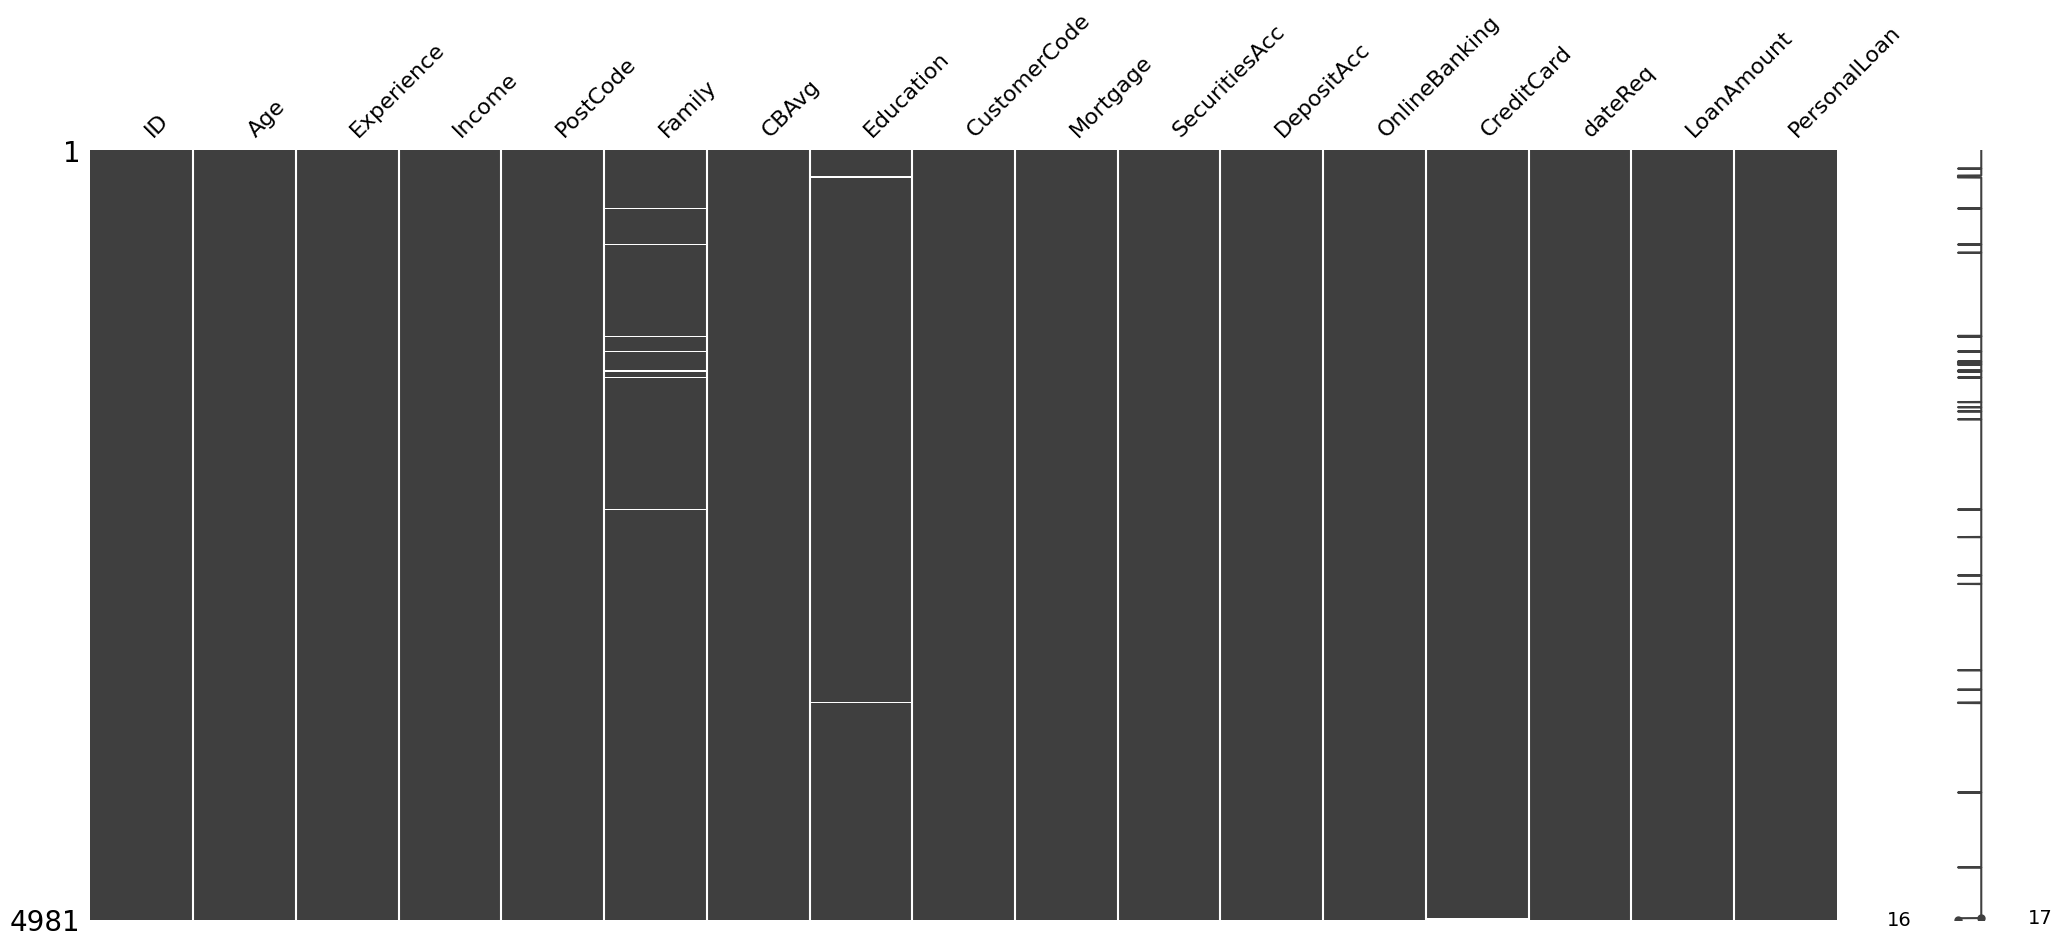

In [73]:
import missingno as msno

msno.matrix(df)
plt.show()

There are 25 missing values in the family column, 17 missing values in the education column, and 13 missing values in the credit card column. 
* For family, we will replace the missing values with 1 which is the lowest value in the series. 
* For education, we will replace the missing values with 0, creating a new category which will represent no educational experience.
* For credit card, we will replace the missing values with 0, as it is a dichotomic variable. 

In [74]:
# Replace missing values in 'Family' with 1
df['Family'].fillna(1, inplace=True)

# Replace missing values in 'CreditCard' and 'Education' with 0
df['CreditCard'].fillna(0, inplace=True)
df['Education'].fillna(0, inplace=True)

### 1.2 Handling Irrelevant Columns

The CustomerCode column contains the customer's code number. We will drop this column as it is not relevant to our analysis. Additionally from a business perspective, this could be considered individually identifiable information and we will remove it from the dataset for privacy reasons. We will also drop the ID column as it is not relevant to our analysis.

In [75]:
# Drop the CustomerCode column
df.drop('CustomerCode', axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True)

### 1.3 Handling Categorial Columns

Two columns are categorical: PostCode and dateReq. In regards to PostCode, the first two digits can be used to identify the geographical region. From the code below, we can see that all post codes start with a 2, and the second digits are all either 0-6. This means that we could either do one-hot encoding for the second digit, or we simply could modify the column from its 5 digit PostCode to be a single digit which is the second digit. In regards to the dateReq, we are going to view the week where the customer applied to the loan. The range of these loans is October 12-November 8. This is a 5 week span where the weeks are: (Week 1: 10/9-10/15  Week 2: 10/16-10/22  Week 3: 10/23-29  Week 4: 10/30-11/5 Week 5: 11/6-11/12). This means could use one hot encoding to create 5 different week columns. There are a few considerations we have to make before deciding on one-hot encoding:
* Dimensionality: With 7 different second digit possibilites, we'll add 7 new features to the dataset. This will increase the dimensionality of your dataset which can cause some models to underperform.
* Sparsity: The resulting dataset will be sparse (mostly zeros). Some algorithms handle sparse data well, but others might struggle or become inefficient.
* Model Complexity and Overfitting: More features can lead to a more complex model, which increases the risk of overfitting. 
* Interpretability: One-hot encoding makes models less interpretable, especially with a large number of categories. 

While these are important things to consider, we are only adding 7 (postcodes) + 5 (weeks) = 12 columns to the dataset, which is not a significant increase in dimensionality. ML BANK wants to make segmentation by Custormer’s Region and the week where the customer applied by the Loan, so we will use one-hot encoding for both of these columns.

In [76]:
# Extracting the first and second digits of the postcodes
first_digit = df['PostCode'].astype(str).str[0]
second_digit = df['PostCode'].astype(str).str[1]

# Print the unique first and second digits
unique_first_digits = first_digit.unique()
unique_second_digits = second_digit.unique()

print("Unique first digits:", unique_first_digits)
print("Unique second digits:", unique_second_digits)


Unique first digits: ['2']
Unique second digits: ['1' '0' '4' '2' '3' '5' '6']


In [77]:
# Convert 'dateReq' to datetime
df['dateReq'] = pd.to_datetime(df['dateReq'], format='%d/%m/%Y')

# Extracting unique days, months, and years
unique_days = df['dateReq'].dt.day.unique()
unique_months = df['dateReq'].dt.month.unique()
unique_years = df['dateReq'].dt.year.unique()

print("Unique days:", unique_days)
print("Unique months:", unique_months)
print("Unique years:", unique_years)

Unique days: [12 13 14 15 18 19 20 21 22 25 26 27 28 29  2  3  4  5  8]
Unique months: [10 11]
Unique years: [2022]


Go to section 1.5 for the pre-processing code where we will handle the one-hot encoding for these two columns. 

### 1.4 Handling Outliers

Now let's look for outliers that might influence the data in the continuous variables. We will use boxplots to visualize the outliers.

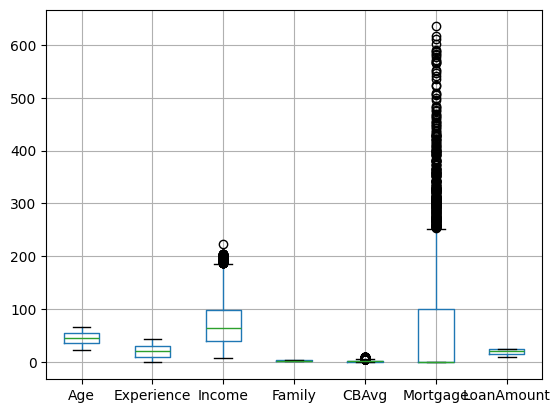

In [78]:
# Create boxplots for the numerical variables
df.boxplot(column=['Age', 'Experience', 'Income', 'Family', 'CBAvg', 'Mortgage', 'LoanAmount', ])

# Show the plot
plt.show()


From these initial boxplots, we can see that there are outliers in the Income, CBAvg, and Mortgage variables. Let's take a closer look at these variables.

##### Income

count    4981.000000
mean       73.784381
std        46.005396
min         8.000000
25%        39.000000
50%        64.000000
75%        98.000000
max       224.000000
Name: Income, dtype: float64


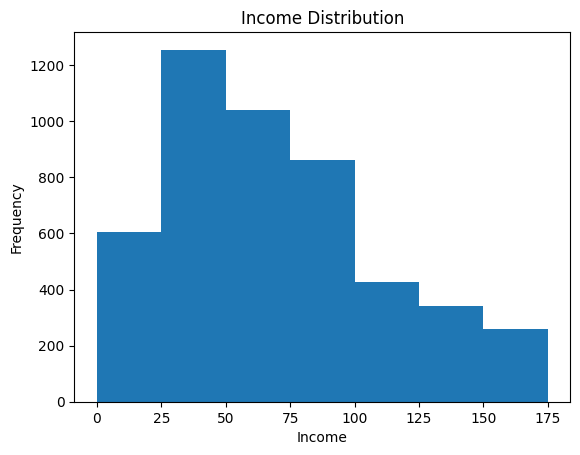

In [79]:
print(df['Income'].describe())
# Create a histogram for the 'Income' variable using plt

# make the bins every 25
plt.hist(df['Income'], bins=range(0, 200, 25))
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()


This distribution is skewed to the right and that leads to the outliers. Let's go ahead and remove outliers that are more than 3 standard deviations away from the mean.

In [80]:
import numpy as np

# Calculate the z-scores for the 'CBAvg' column
z_scores = np.abs((df['Income'] - df['Income'].mean()) / df['Income'].std())

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Remove outliers from the 'CBAvg' column
df = df[z_scores <= threshold]

# print number of rows removed
print(f"Number of rows removed: {len(z_scores) - len(df)}")


Number of rows removed: 1


##### CBAvg

count    4980.000000
mean        1.937319
std         1.747565
min         0.000000
25%         0.700000
50%         1.500000
75%         2.500000
max        10.000000
Name: CBAvg, dtype: float64


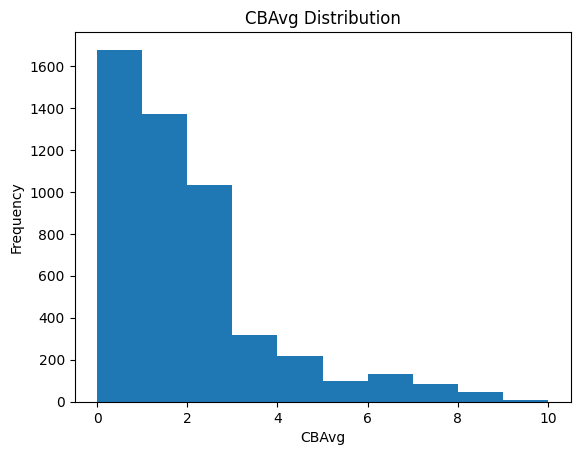

In [81]:
print(df['CBAvg'].describe())
# Create a histogram for the 'Income' variable using plt

# make the bins every 25
plt.hist(df['CBAvg'], bins=10)
plt.xlabel('CBAvg')
plt.ylabel('Frequency')
plt.title('CBAvg Distribution')
plt.show()


Let's do the same here and remove outliers that are more than 3 standard deviations away from the mean.

In [82]:
# Calculate the z-scores for the 'CBAvg' column
z_scores = np.abs((df['CBAvg'] - df['CBAvg'].mean()) / df['CBAvg'].std())

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Remove outliers from the 'CBAvg' column
df = df[z_scores <= threshold]

# print number of rows removed
print(f"Number of rows removed: {len(z_scores) - len(df)}")

Number of rows removed: 121


##### Mortgage

count    4859.000000
mean       55.506071
std        99.487423
min         0.000000
25%         0.000000
50%         0.000000
75%       100.500000
max       635.000000
Name: Mortgage, dtype: float64


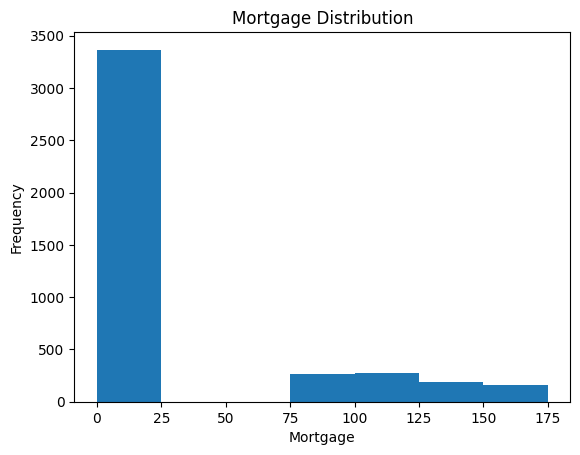

In [83]:
print(df['Mortgage'].describe())
# Create a histogram for the 'Income' variable using plt

# make the bins every 25
plt.hist(df['Mortgage'], bins=range(0, 200, 25))
plt.xlabel('Mortgage')
plt.ylabel('Frequency')
plt.title('Mortgage Distribution')
plt.show()


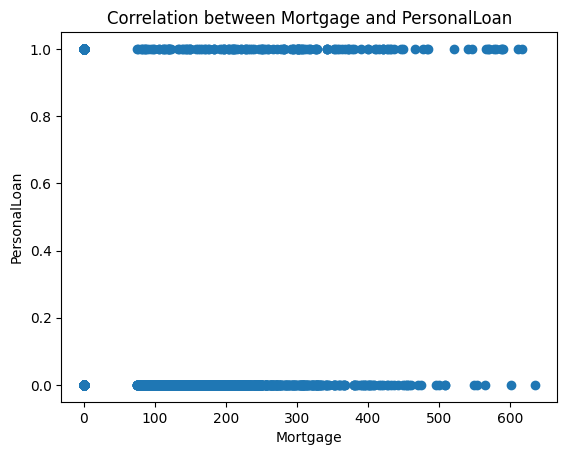

In [84]:
plt.scatter(df['Mortgage'], df['PersonalLoan'])
plt.xlabel('Mortgage')
plt.ylabel('PersonalLoan')
plt.title('Correlation between Mortgage and PersonalLoan')
plt.show()


After taking a look at the distribution of Mortgage and the correlation with the target variable, we can see that the outliers exist because around 50% of the customers have no mortgage. We will not remove these outliers as they are not errors in the data, but rather a reflection of the data.



### 1.5 Pre-Processing

Importing necessary libaries

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

Create function to convert the dateReg column to week number. What this does is creates bins for the 5 week span evident in the data where the weeks are: Week 1: 10/9-10/15  Week 2: 10/16-10/22  Week 3: 10/23-29  Week 4: 10/30-11/5 Week 5: 11/6-11/12.

In [86]:
# Function to categorize 'dateReq' into weeks
def categorize_weeks(X):
    # Convert to datetime
    dates = pd.to_datetime(df['dateReq'])
    # Define the week categories based on the date ranges
    bins = pd.to_datetime(['09/10/2022', '16/10/2022', '23/10/2022', '30/10/2022', '06/11/2022', '13/11/2022'], format='%d/%m/%Y')
    week_labels = [1, 2, 3, 4, 5]
    week_categories = pd.cut(dates, bins=bins, labels=week_labels, right=False)
    return np.array(week_categories).reshape(-1, 1)

# categorize_weeks(X=df[['dateReq']])

# Replace date column with categorize_weeks
df['dateReq'] = categorize_weeks(X=df[['dateReq']])

Create a function to handle postal codes. These postal codes will be replaced by their second digit as the first two digits describe the region, but the first digit is always 2, so only the 2nd digit is significant.

In [87]:
# Replace the 5 digit post code with the 2nd digit
df['PostCode'] = df['PostCode'].astype(str).str[1].astype(int)

Now we create the onehot_encoder and use a column transformer to transform the dateReq column while keeping the other columns unaltered.

In [88]:
from sklearn import set_config

# set the global configuration to keep the DataFrame structure in the transformed data
set_config(display='diagram', transform_output = 'pandas')

# Create separate instances of OneHotEncoder
onehot_encoder_dateReq = OneHotEncoder(sparse=False)
onehot_encoder_postCode = OneHotEncoder(sparse=False)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot_dateReq', onehot_encoder_dateReq, ['dateReq']),
        ('onehot_postCode', onehot_encoder_postCode, ['PostCode'])
    ],
    remainder='passthrough'  # keeps all other columns untouched
)

Finally we fit the date with the preprocessor.

In [89]:
df_transformed = preprocessor.fit_transform(df)


/Users/joaocarvalho/Documents/School/Abroad2023/UC3M-MLBD/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/joaocarvalho/Documents/School/Abroad2023/UC3M-MLBD/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


From printing the columns of our new data frame, we can see that the one hot encoding has created 5 new columns where the 

In [90]:
print(df_transformed.columns)
print(df.columns)

Index(['onehot_dateReq__dateReq_1', 'onehot_dateReq__dateReq_2',
       'onehot_dateReq__dateReq_3', 'onehot_dateReq__dateReq_4',
       'onehot_dateReq__dateReq_5', 'onehot_postCode__PostCode_0',
       'onehot_postCode__PostCode_1', 'onehot_postCode__PostCode_2',
       'onehot_postCode__PostCode_3', 'onehot_postCode__PostCode_4',
       'onehot_postCode__PostCode_5', 'onehot_postCode__PostCode_6',
       'remainder__Age', 'remainder__Experience', 'remainder__Income',
       'remainder__Family', 'remainder__CBAvg', 'remainder__Education',
       'remainder__Mortgage', 'remainder__SecuritiesAcc',
       'remainder__DepositAcc', 'remainder__OnlineBanking',
       'remainder__CreditCard', 'remainder__LoanAmount',
       'remainder__PersonalLoan'],
      dtype='object')
Index(['Age', 'Experience', 'Income', 'PostCode', 'Family', 'CBAvg',
       'Education', 'Mortgage', 'SecuritiesAcc', 'DepositAcc', 'OnlineBanking',
       'CreditCard', 'dateReq', 'LoanAmount', 'PersonalLoan'],
      dty

Cleaning up the column names to make it more readable

In [91]:
week_mapping = {f'onehot_dateReq__dateReq_{i}': f'Week {i}' for i in range(1, 6)}
region_mapping = {f'onehot_postCode__PostCode_{i}': f'Region {i}' for i in range(0, 7)}

# Renaming columns
renamed_columns = []
for col in df_transformed.columns:
    if col in week_mapping:
        # Rename week columns
        renamed_columns.append(week_mapping[col])
    elif col in region_mapping:
        # Rename region columns
        renamed_columns.append(region_mapping[col])
    else:
        # Remove 'remainder__' prefix from other columns
        renamed_columns.append(col.replace('remainder__', ''))

# Result
df_transformed.columns = renamed_columns
print(df_transformed.columns)

df = df_transformed

Index(['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Region 0',
       'Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5', 'Region 6',
       'Age', 'Experience', 'Income', 'Family', 'CBAvg', 'Education',
       'Mortgage', 'SecuritiesAcc', 'DepositAcc', 'OnlineBanking',
       'CreditCard', 'LoanAmount', 'PersonalLoan'],
      dtype='object')


### 1.6 The final dataset

After all of our data cleaning, we have a dataset with X rows and X columns. Now let's take a look at the dataset we'll be using.

In [92]:
X = df.drop('PersonalLoan', axis=1)
y = df['PersonalLoan']

## Part 2: Basic Models

### 2.0 Setup

Let's make a function for calculating the metrics we will be using to evaluate our models. These metrics allow us to better understand the performance of our models given that the data is imbalanced.

In [93]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, classification_report, precision_score, f1_score, confusion_matrix

def get_metrics(model_name,y_test, y_pred):

    # Make a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate the balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Calculate the recall
    recall = recall_score(y_test, y_pred)

    # Calculate the precision
    precision = precision_score(y_test, y_pred)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    # Create a classification report
    report = classification_report(y_test, y_pred)

    # Print the scores
    print(f"{model_name} Model Confusion Matrix:\n", cm)
    print(f"{model_name}Model Accuracy:", accuracy)
    print(f"{model_name}Model Balanced Accuracy:", balanced_accuracy)
    print(f"{model_name}Model Recall:", recall)
    print(f"{model_name}Model Precision:", precision)
    print(f"{model_name}Model F1 Score:", f1)
    print(f"{model_name} Model Classification Report:\n", report)


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)


We'll make a DummyClassifier model to compare the results of our KNN model to a trivial model that just predicts the mean of the training data. This will be the baseline model that we will try to beat for all of our models.

In [95]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
print(dummy_classifier.score(X_test, y_test))
y_pred_dummy = dummy_classifier.predict(X_test)

0.9084362139917695


### Model 1: KNN

Let's split the data, using stratified sampling to ensure that the training and test sets have the same proportion of yes/no values as the original dataset.

In [96]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the model, leaving default values for all hyperparameters which is n= 5
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# We'll now make our predictions
y_pred = knn.predict(X_test)

Let's take a look at metrics for the trivial dummy model so we can compare it to our future models.

In [97]:
get_metrics("Dummy",y_test, y_pred_dummy)

Dummy Model Confusion Matrix:
 [[883   0]
 [ 89   0]]
DummyModel Accuracy: 0.9084362139917695
DummyModel Balanced Accuracy: 0.5
DummyModel Recall: 0.0
DummyModel Precision: 0.0
DummyModel F1 Score: 0.0
Dummy Model Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       883
           1       0.00      0.00      0.00        89

    accuracy                           0.91       972
   macro avg       0.45      0.50      0.48       972
weighted avg       0.83      0.91      0.86       972



/Users/joaocarvalho/Documents/School/Abroad2023/UC3M-MLBD/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaocarvalho/Documents/School/Abroad2023/UC3M-MLBD/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaocarvalho/Documents/School/Abroad2023/UC3M-MLBD/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Now let's look at the metrics for our KNN model and compare it to the dummy model.

In [98]:
get_metrics("KNN",y_test, y_pred)

KNN Model Confusion Matrix:
 [[858  25]
 [ 49  40]]
KNNModel Accuracy: 0.9238683127572016
KNNModel Balanced Accuracy: 0.710562815732882
KNNModel Recall: 0.449438202247191
KNNModel Precision: 0.6153846153846154
KNNModel F1 Score: 0.5194805194805195
KNN Model Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       883
           1       0.62      0.45      0.52        89

    accuracy                           0.92       972
   macro avg       0.78      0.71      0.74       972
weighted avg       0.92      0.92      0.92       972



Looking at these stats, the KNN model is actually performing worse overall than the dummy model. Additionally, looking at the confusion matrix, we can see that the model is predicting a large number of false positives and false negatives. Additionally the balanced accuracy is at 0.62 which we definitely want to improve on. Let's see if a tree based model will perform better.

#### Stratified KFold Cross Validation

Cross validation is important as it provides a more accurate measure of a model's performance by using multiple data splits, reducing the likelihood of overfitting and ensuring the model's generalizability. It allows for efficient use of limited data, enabling both training and validation on different subsets, which is important for fine-tuning model parameters. Here, we are using stratification because it ensures that each fold maintains the same proportion of class labels as the original dataset, which is especially useful for imbalanced datasets.

Let's start by defining a new metrics function that will be used for cross validation. We will use the same metrics as before, but we will also include the standard deviation of the metrics across the folds to get a better idea of the model's performance.

In [99]:

def get_kfold_metrics(scoring, model, X, y, cv):
    
    mat = confusion_matrix(y, model.predict(X))
    print(f"Confusion Matrix:\n {mat}")
    
    for metric in scoring:
        scores = cross_val_score(model, X, y, cv=cv, scoring=metric)
        print(f"Mean {metric}: {scores.mean():.3f} ")
        print(f"Standard deviation of scores: {scores.std():.3f}")
        
        
    # print the standard deviation of the scores
        
    report = classification_report(y, model.predict(X))
    print(f"Classification Report:\n {report}")
    

Now, let's define the parameters for the cross validation metrics.

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score


# Define the cross validation scheme.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# create a scoring for cross val score using balanced accuracy and recall
scoring = {'accuracy','balanced_accuracy', 'recall', 'precision', 'f1'}

get_kfold_metrics(scoring, knn, X, y,cv)

Confusion Matrix:
 [[4325   87]
 [ 190  257]]
Mean recall: 0.481 
Standard deviation of scores: 0.066
Mean precision: 0.616 
Standard deviation of scores: 0.040
Mean f1: 0.538 
Standard deviation of scores: 0.045
Mean balanced_accuracy: 0.725 
Standard deviation of scores: 0.032
Mean accuracy: 0.924 
Standard deviation of scores: 0.006
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4412
           1       0.75      0.57      0.65       447

    accuracy                           0.94      4859
   macro avg       0.85      0.78      0.81      4859
weighted avg       0.94      0.94      0.94      4859



These scores better represent the performance of our model and from here on out we will be using these cross validation metrics to evaluate our models.

### Basic Model 2: Decision Tree

In [101]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [102]:
# get_metrics("Decision Tree",y_test_untrans, y_pred_tree)

get_kfold_metrics(scoring, tree, X, y,cv)


Confusion Matrix:
 [[4409    3]
 [   7  440]]
Mean recall: 0.888 
Standard deviation of scores: 0.046
Mean precision: 0.900 
Standard deviation of scores: 0.027
Mean f1: 0.902 
Standard deviation of scores: 0.027
Mean balanced_accuracy: 0.945 
Standard deviation of scores: 0.018
Mean accuracy: 0.983 
Standard deviation of scores: 0.006
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       0.99      0.98      0.99       447

    accuracy                           1.00      4859
   macro avg       1.00      0.99      0.99      4859
weighted avg       1.00      1.00      1.00      4859



We can see that the decision tree model is performing much better than the KNN model. The mean balanced accuracy is at ~0.945 which is an improvement from the KNN model and better than the regular accuracy on the trivial model. Additionally, the confusion matrix shows that the model is predicting less false positives with 9, and less false negatives with only 4. It's precision and recall both are at around 0..89 and 0.898 respectively, which let's us be pretty confident that when we see a positive prediction, it is a true positive.

Now let us use feature selection to see if we can improve the performance of our models.

## 2.1 Basic Models with feature selection

### KNN with feature selection

In [104]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config


pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=5)),
    ('knn', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)

# y_pred_pipeline = pipeline.predict(X_test)

scaler = pipeline_knn.named_steps['scaler']

# Access the scaler to be able to get the names of the features
feature_names = scaler.get_feature_names_out()

# Access the selector to be able to get the scores of the features
selector = pipeline_knn.named_steps['selector']
feature_scores = selector.scores_

# Pair the feature names with their scores
feature_scores_list = [(feature, score) for feature, score in zip(feature_names, feature_scores)]

# Sort the list by score in descending order
feature_scores_list = sorted(feature_scores_list, key=lambda x: x[1], reverse=True)

# Display the list of features with their scores
print('Feature scores for all features sorted by score:')
for score in feature_scores_list:
    print(score)

print(feature_names)
print(feature_scores)



Feature scores for all features sorted by score:
('Income', 1365.3260312118175)
('CBAvg', 664.0714786881603)
('DepositAcc', 414.42230832376106)
('Education', 83.38991841801754)
('Mortgage', 70.51270205380072)
('LoanAmount', 48.93979544585773)
('Family', 9.024999777881431)
('SecuritiesAcc', 3.8950618390761775)
('Region 6', 1.338129578503883)
('Week 2', 1.0233080589319243)
('Week 4', 0.7831257091119932)
('Week 5', 0.5213640797328136)
('Region 3', 0.3615481474794917)
('Region 0', 0.2285618634174442)
('Region 4', 0.22414350039598754)
('Region 5', 0.19215605689891727)
('Week 1', 0.1825927854830487)
('Week 3', 0.12628821092566186)
('Region 2', 0.11665259614166265)
('Region 1', 0.08039537883290498)
('CreditCard', 0.014721944303916466)
('OnlineBanking', 0.011671117450329184)
('Age', 0.004407817339235349)
('Experience', 0.00031972873773183154)
['Week 1' 'Week 2' 'Week 3' 'Week 4' 'Week 5' 'Region 0' 'Region 1'
 'Region 2' 'Region 3' 'Region 4' 'Region 5' 'Region 6' 'Age' 'Experience'
 'Income' 

The top 5 features are: Income, CBAvg, DepositACC, Mortgage, and Education. Let's check the metrics to see if the KNN model performs better with these features.

Score the pipeline model's predictions


In [105]:
get_kfold_metrics(scoring, pipeline_knn, X, y,cv)

Confusion Matrix:
 [[4386   26]
 [ 108  339]]
Mean recall: 0.685 
Standard deviation of scores: 0.046
Mean precision: 0.899 
Standard deviation of scores: 0.050
Mean f1: 0.776 
Standard deviation of scores: 0.040
Mean balanced_accuracy: 0.838 
Standard deviation of scores: 0.024
Mean accuracy: 0.964 
Standard deviation of scores: 0.006
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4412
           1       0.93      0.76      0.83       447

    accuracy                           0.97      4859
   macro avg       0.95      0.88      0.91      4859
weighted avg       0.97      0.97      0.97      4859



As we can see the Model's performance has improved with the feature selection. The balanced accuracy is now at ~0.957 which is an improvement from the previous iteration. Additionally, the confusion matrix shows that the model is predicting less false positives and false negatives with 5 false negatives and 7 false positives. This is definitely a step in the right direction, let's see if the decision tree model improves with feature selection.

### Decision Tree with feature selection

In [106]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config


pipeline_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=5)),
    ('tree', DecisionTreeClassifier(random_state=seed)),
])

pipeline_tree.fit(X_train, y_train)

# Access the scaler to be able to get the names of the features
scaler = pipeline_tree.named_steps['scaler']
feature_names = scaler.get_feature_names_out()

# Access the selector to be able to get the scores of the features
selector = pipeline_tree.named_steps['selector']
feature_scores = selector.scores_

# Pair the feature names with their scores
feature_scores_list = [(feature, score) for feature, score in zip(feature_names, feature_scores)]

# Sort the list by score in descending order
feature_scores_list = sorted(feature_scores_list, key=lambda x: x[1], reverse=True)

# Display the list of features with their scores
print('Feature scores for all features sorted by score:')
for score in feature_scores_list:
    print(score)

Feature scores for all features sorted by score:
('Income', 1365.3260312118175)
('CBAvg', 664.0714786881603)
('DepositAcc', 414.42230832376106)
('Education', 83.38991841801754)
('Mortgage', 70.51270205380072)
('LoanAmount', 48.93979544585773)
('Family', 9.024999777881431)
('SecuritiesAcc', 3.8950618390761775)
('Region 6', 1.338129578503883)
('Week 2', 1.0233080589319243)
('Week 4', 0.7831257091119932)
('Week 5', 0.5213640797328136)
('Region 3', 0.3615481474794917)
('Region 0', 0.2285618634174442)
('Region 4', 0.22414350039598754)
('Region 5', 0.19215605689891727)
('Week 1', 0.1825927854830487)
('Week 3', 0.12628821092566186)
('Region 2', 0.11665259614166265)
('Region 1', 0.08039537883290498)
('CreditCard', 0.014721944303916466)
('OnlineBanking', 0.011671117450329184)
('Age', 0.004407817339235349)
('Experience', 0.00031972873773183154)


The top 5 features are the same as the KNN model: Income, CBAvg, DepositACC, Mortgage, and Education. Let's check the metrics to see if the decision tree model performs better with these features.

In [107]:
get_kfold_metrics(scoring, pipeline_tree, X, y,cv)

Confusion Matrix:
 [[4388   24]
 [  24  423]]
Mean recall: 0.774 
Standard deviation of scores: 0.027
Mean precision: 0.800 
Standard deviation of scores: 0.037
Mean f1: 0.787 
Standard deviation of scores: 0.026
Mean balanced_accuracy: 0.877 
Standard deviation of scores: 0.014
Mean accuracy: 0.961 
Standard deviation of scores: 0.005
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4412
           1       0.95      0.95      0.95       447

    accuracy                           0.99      4859
   macro avg       0.97      0.97      0.97      4859
weighted avg       0.99      0.99      0.99      4859



The feature selection has actually made the model perform worse. The accuracy is now at 0.96 instead of 0.98, balanced accuracy is now at ~0.877 which is a decrease from the previous iteration at 0.96. Recall and Precision are both down from 0.90 to 0.774 and 0.80 respectively. Additionally, the confusion matrix shows that the model is predicting more false positives and false negatives with 24 false negatives and 24 false positives. This is definitely a step in the wrong direction, and we will not be using feature selection for the decision tree model. However, the balanced accuracy is still higher than that of the KNN model with feature selection, so it might be worth it to explore tuning the number of features we select.

#### Imbalanced Data

The data we're working with is imbalanced as a vast majority of the customers did not take out a loan. This can lead to a model that is biased towards the majority class. We can see this in the confusion matrix where the model is predicting a large number of false negatives. To combat this, we can use SMOTE to oversample the minority class and undersample the majority class. This will create a more balanced dataset that will hopefully lead to a model that is not biased towards the majority class, however it will also lead to a smaller dataset. Let's see if this improves the performance of our models.

In [108]:
# First let's see the distribution of the target variable
class_distribution = y_train.value_counts()
print(class_distribution)

PersonalLoan
0    3529
1     358
Name: count, dtype: int64


In [109]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Note: Using imblearn's Pipeline

pipeline_knn_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('selector', SelectKBest(f_classif, k=5)),
    ('knn', KNeighborsClassifier())
])

pipeline_knn_smote.fit(X_train, y_train)

get_kfold_metrics(scoring, pipeline_knn_smote, X, y,cv)




Confusion Matrix:
 [[4290  122]
 [  26  421]]
Mean recall: 0.868 
Standard deviation of scores: 0.027
Mean precision: 0.712 
Standard deviation of scores: 0.061
Mean f1: 0.781 
Standard deviation of scores: 0.041
Mean balanced_accuracy: 0.916 
Standard deviation of scores: 0.015
Mean accuracy: 0.955 
Standard deviation of scores: 0.010
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      4412
           1       0.78      0.94      0.85       447

    accuracy                           0.97      4859
   macro avg       0.88      0.96      0.92      4859
weighted avg       0.97      0.97      0.97      4859



Using SMOTE to address the imbalanced data problem gets balanced accuracy up to 0.91, up from 0.90. Recall and Precision both improved as well but remain below the values for decision trees. So though it slightly improves the performance, nothing extreme occurred. Let's see what happens if we do the same for the decision tree model.

In [110]:

# Redefine the tree pipeline with SMOTE
pipeline_tree_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('selector', SelectKBest(f_classif, k=5)),
    ('tree', DecisionTreeClassifier(random_state=seed))
])

pipeline_tree_smote.fit(X_train, y_train)

get_kfold_metrics(scoring, pipeline_tree_smote, X, y,cv)


Confusion Matrix:
 [[4396   16]
 [  16  431]]
Mean recall: 0.852 
Standard deviation of scores: 0.037
Mean precision: 0.837 
Standard deviation of scores: 0.026
Mean f1: 0.844 
Standard deviation of scores: 0.016
Mean balanced_accuracy: 0.918 
Standard deviation of scores: 0.017
Mean accuracy: 0.971 
Standard deviation of scores: 0.003
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       0.96      0.96      0.96       447

    accuracy                           0.99      4859
   macro avg       0.98      0.98      0.98      4859
weighted avg       0.99      0.99      0.99      4859



There is a larger improvement here from the last iteration as balanced accuracy is now at 0.91, up from 0.90. However, this is still below the value of 0.968 achieved by the decision tree model without feature selection or SMOTE. This solidifies our decision to tune the number of features we use to train the advanced models. It could be that k = 5 for feature selection just isn't enough features to train the model on. 

Given that the decision tree model is performing better than the KNN model, we will use tree based models.

## Part 3: Advanced Models

### 3.0 Let's do Random Forest with no HPT

In [111]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
forest = RandomForestClassifier(random_state=seed)
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)

# Get the score from the decision tree model
forest_score = forest.score(X_test, y_test)
print("Forest Model Score:", forest_score)

Forest Model Score: 0.9866255144032922


Now let's get more accuracy measurements: Precision, Recall, and F1-Score:

In [112]:
get_kfold_metrics(scoring, forest, X, y,cv)


Confusion Matrix:
 [[4412    0]
 [  13  434]]
Mean recall: 0.855 
Standard deviation of scores: 0.049
Mean precision: 0.997 
Standard deviation of scores: 0.006
Mean f1: 0.920 
Standard deviation of scores: 0.030
Mean balanced_accuracy: 0.927 
Standard deviation of scores: 0.025
Mean accuracy: 0.986 
Standard deviation of scores: 0.005
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       1.00      0.97      0.99       447

    accuracy                           1.00      4859
   macro avg       1.00      0.99      0.99      4859
weighted avg       1.00      1.00      1.00      4859



Now let me try some feature selection to see if I can improve the model's performance.

In [113]:

pipeline_forest = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('selector', SelectKBest(f_classif, k=5)),
    ('tree', RandomForestClassifier(random_state=seed))
])

pipeline_forest.fit(X_train, y_train)

y_pred_pipeline_forest = pipeline_forest.predict(X_test)


# Access the scaler to be able to get the names of the features
scaler = pipeline_forest.named_steps['scaler']
feature_names = scaler.get_feature_names_out()

# Access the selector to be able to get the scores of the features
selector = pipeline_forest.named_steps['selector']
feature_scores = selector.scores_

# Pair the feature names with their scores
feature_scores_list = [(feature, score) for feature, score in zip(feature_names, feature_scores)]

# Sort the list by score in descending order
feature_scores_list = sorted(feature_scores_list, key=lambda x: x[1], reverse=True)

# Display the list of features with their scores
print('Feature scores for all features sorted by score:')
for score in feature_scores_list:
    print(score)

Feature scores for all features sorted by score:
('Income', 9698.252306125543)
('CBAvg', 3185.0135319563847)
('DepositAcc', 920.8425675993345)
('Education', 564.763926109521)
('LoanAmount', 370.0587389811046)
('Mortgage', 147.65996252567612)
('Family', 51.38309084173657)
('SecuritiesAcc', 19.463830385502288)
('Region 6', 17.0673804055045)
('Week 4', 14.31831435304643)
('Week 3', 14.262441999071624)
('Region 3', 13.252309157826197)
('Region 4', 10.825927938701048)
('Week 1', 10.391275364827685)
('CreditCard', 7.92227259560139)
('Week 5', 6.955357080670259)
('Week 2', 4.508326608749454)
('Region 1', 3.4674301088182933)
('Region 2', 2.4251458945251776)
('Region 5', 1.6133663401652834)
('OnlineBanking', 1.2042692189856852)
('Experience', 0.13020717966645917)
('Region 0', 0.09027643309206076)
('Age', 0.08087353304460287)


In [114]:
get_kfold_metrics(scoring, pipeline_forest, X, y,cv)

Confusion Matrix:
 [[4399   13]
 [  14  433]]
Mean recall: 0.848 
Standard deviation of scores: 0.025
Mean precision: 0.883 
Standard deviation of scores: 0.052
Mean f1: 0.864 
Standard deviation of scores: 0.027
Mean balanced_accuracy: 0.918 
Standard deviation of scores: 0.012
Mean accuracy: 0.975 
Standard deviation of scores: 0.006
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       0.97      0.97      0.97       447

    accuracy                           0.99      4859
   macro avg       0.98      0.98      0.98      4859
weighted avg       0.99      0.99      0.99      4859



It got slightly worse with feature selection but that was because k=5. Now we're going to loop through the different k values 1 through 25 to determine which number of features achieves the best scores when running Random Forests with feature selection.

In [115]:

# Best score and corresponding k
best_score = 0
best_k = 0

# Loop through k = 1 to 25
for k in range(1, 25):
    # Create the pipeline with current k
    pipeline_forest = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=seed)),
        ('selector', SelectKBest(f_classif, k=k)),
        ('forest', RandomForestClassifier(random_state=seed))
    ])

    # Fit the pipeline
    pipeline_forest.fit(X_train, y_train)

    # Predict on the test set
    y_pred_pipeline_forest = pipeline_forest.predict(X_test)

    # Evaluate the model
    score = balanced_accuracy_score(y_test, y_pred_pipeline_forest)

    # Update the best score and best k
    if score > best_score:
        best_score = score
        best_k = k

    print(f"Score for k={k}: {score}")

# Print the best k
print(f"Best k: {best_k} with score: {best_score}")

# Create and fit the pipeline with the best k
best_pipeline_forest = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('selector', SelectKBest(f_classif, k=best_k)),
    ('forest', RandomForestClassifier(random_state=seed))
])

best_pipeline_forest.fit(X_train, y_train)

# Use get_kfold_metrics function for the best pipeline
get_kfold_metrics(scoring, best_pipeline_forest, X, y, cv)

Score for k=1: 0.6768104139361472
Score for k=2: 0.8671663252191838
Score for k=3: 0.8845865092190821
Score for k=4: 0.8740949520913128
Score for k=5: 0.914553297619199
Score for k=6: 0.9314072302034688
Score for k=7: 0.9584091516408566
Score for k=8: 0.9595416544721137
Score for k=9: 0.9533574255283953
Score for k=10: 0.963460877753318
Score for k=11: 0.9533574255283953
Score for k=12: 0.9584091516408566
Score for k=13: 0.9522249226971382
Score for k=14: 0.9527911741127668
Score for k=15: 0.9533574255283953
Score for k=16: 0.9572766488095996
Score for k=17: 0.9466069451690483
Score for k=18: 0.964593380584575
Score for k=19: 0.9522249226971382
Score for k=20: 0.9578429002252281
Score for k=21: 0.9471731965846768
Score for k=22: 0.9539236769440238
Score for k=23: 0.9516586712815096
Score for k=24: 0.9527911741127668
Best k: 18 with score: 0.964593380584575
Confusion Matrix:
 [[4409    3]
 [   6  441]]
Mean recall: 0.915 
Standard deviation of scores: 0.037
Mean precision: 0.948 
Standa

### Now let's HPT the Random Forest.

In [123]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 100)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 50)]
min_samples_split = [2, 3, 4, 5, 6, 7, 10, 13, 14, 15, 18, 20]
min_samples_leaf = [1, 2, 3, 4, 6, 8]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf    
    
}

# Instantiate the random forest classifier
forest_hpt = RandomForestClassifier(random_state=seed)

# instantiate the random search model
random_search = RandomizedSearchCV(
    estimator=forest_hpt,
    param_distributions=param_grid,
    n_iter=100,
    scoring='balanced_accuracy',
    cv=cv,
    verbose=1,
    random_state=seed,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best parameters
print(random_search.best_params_)
# Get the best score
print(random_search.best_score_)
# Get the best model

best_model = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 480, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 103}
0.9230438184663537


In [124]:
get_kfold_metrics(scoring, best_model, X, y, cv)

Confusion Matrix:
 [[4412    0]
 [  14  433]]
Mean recall: 0.861 
Standard deviation of scores: 0.056
Mean precision: 1.000 
Standard deviation of scores: 0.000
Mean f1: 0.925 
Standard deviation of scores: 0.032
Mean balanced_accuracy: 0.931 
Standard deviation of scores: 0.028
Mean accuracy: 0.987 
Standard deviation of scores: 0.005
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       1.00      0.97      0.98       447

    accuracy                           1.00      4859
   macro avg       1.00      0.98      0.99      4859
weighted avg       1.00      1.00      1.00      4859



### Final Model: Random Forest with HPT and Feature Selection

In [118]:
pipeline_final_model = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('selector', SelectKBest(f_classif, k=best_k)),
    ('forest', best_model)
])


pipeline_final_model.fit(X_train, y_train)

# Use get_kfold_metrics function for the best pipeline
get_kfold_metrics(scoring, pipeline_final_model, X, y, cv)

Confusion Matrix:
 [[4409    3]
 [   7  440]]
Mean recall: 0.917 
Standard deviation of scores: 0.035
Mean precision: 0.948 
Standard deviation of scores: 0.031
Mean f1: 0.932 
Standard deviation of scores: 0.024
Mean balanced_accuracy: 0.956 
Standard deviation of scores: 0.018
Mean accuracy: 0.988 
Standard deviation of scores: 0.004
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4412
           1       0.99      0.98      0.99       447

    accuracy                           1.00      4859
   macro avg       1.00      0.99      0.99      4859
weighted avg       1.00      1.00      1.00      4859



Summary of mean balanced_accuracy:
* Dummy                                                        ~0.500
* KNN                                                          ~0.725
* KNN with Feature Selection k=5                               ~0.838
* KNN with Feature Selection k=5 and Smote                     ~0.916
* Decision Tree                                                ~0.945
* Decision Tree with Feature Selection k=5                     ~0.877
* Decision Tree with Feature Selection k=5 and Smote           ~0.918
* Random Forest with no HPT and no Feature Selection           ~0.927 
* Random Forest with no HPT and Feature Selection k=5          ~0.918
* Random Forest with HPT and no Feature Selection              ~0.931
* Random Forest with no HPT and Feature Selection with k best  ~0.955
* Random Forest with HPT and Feature Selection with k best     ~0.956

Summary of accuracy:
* Dummy                                                        ~0.900
* KNN                                                          ~0.924
* KNN with Feature Selection k=5                               ~0.964
* KNN with Feature Selection k=5 and Smote                     ~0.955
* Decision Tree                                                ~0.983
* Decision Tree with Feature Selection k=5                     ~0.961
* Decision Tree with Feature Selection k=5 and Smote           ~0.971
* Random Forest with no HPT and no Feature Selection           ~0.927 
* Random Forest with no HPT and Feature Selection k=5          ~0.918
* Random Forest with HPT and no Feature Selection              ~0.931
* Random Forest with no HPT and Feature Selection with k best  ~0.955
* Random Forest with HPT and Feature Selection with k best     ~0.988

Summary of recall:
* Dummy                                                        ~0.000
* KNN                                                          ~0.481
* KNN with Feature Selection k=5                               ~0.685
* KNN with Feature Selection k=5 and Smote                     ~0.868
* Decision Tree                                                ~0.888
* Decision Tree with Feature Selection k=5                     ~0.774
* Decision Tree with Feature Selection k=5 and Smote           ~0.852
* Random Forest with no HPT and no Feature Selection           ~0.927 
* Random Forest with no HPT and Feature Selection k=5          ~0.918
* Random Forest with HPT and no Feature Selection              ~0.931
* Random Forest with no HPT and Feature Selection with k best  ~0.955
* Random Forest with HPT and Feature Selection with k best     ~0.917

From these results we see that the best models from each category are:
* Balanced Accuracy: Random Forest with HPT and Feature Selection with k best     ~0.956
* Accuracy: Random Forest with HPT and Feature Selection with k best              ~0.988
* Recall: Random Forest with no HPT and Feature Selection with k best             ~0.955

Estimation of future performance:
* The accuracy score is 0.988. However, due to the imbalanced nature of the data, we ended up going with balanced_accuracy as a more representative metric of the model's performance. 
* The mean balanced_accuracy for Random Forest with HPT and Feature selection with k-best is 0.956. We expect our model to perform with 95.6% accuracy on future data. We also ran a confusion matrix which provides insight into not only the errors made by a classifier but also the types of errors. The 2x2 matrix is defined as the top left are True Negatives, bottom right are True Positives, top right are false positives and bottom left are False negatives. With a matrix of [[4409    3],[7  440]] we expect .14% false positives and 0.06% false negatives. 